# 创建一个关系数据(y=x0^2-x1^2+x1-1)
https://gplearn.readthedocs.io/en/stable/examples.html
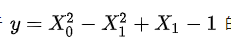

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import sklearn

x0 = np.arange(-1, 1, 1/10.)
x1 = np.arange(-1, 1, 1/10.)
x0, x1 = np.meshgrid(x0, x1)
y_truth = x0**2 - x1**2 + x1 - 1

ax = plt.figure().gca(projection='3d')
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
surf = ax.plot_surface(x0, x1, y_truth, rstride=1, cstride=1,
                       color='green', alpha=0.5)
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  # Remove the CWD from sys.path while we load stuff.


<Figure size 640x480 with 1 Axes>

In [2]:
rng = sklearn.utils.check_random_state(0)

# Training samples
X_train = rng.uniform(-1, 1, 100).reshape(50, 2)
y_train = X_train[:, 0]**2 - X_train[:, 1]**2 + X_train[:, 1] - 1
print(X_train.shape, y_train.shape)

# Testing samples
X_test = rng.uniform(-1, 1, 100).reshape(50, 2)
y_test = X_test[:, 0]**2 - X_test[:, 1]**2 + X_test[:, 1] - 1

(50, 2) (50,)


# GPLearn

## 训练一个SymbolicRegressor

In [11]:
from gplearn.genetic import SymbolicRegressor

In [12]:
est_gp = SymbolicRegressor(population_size=5000,         # The number of programs in each generation
                           generations=20,               # The number of generations to evolve.
                           tournament_size=20,           # The number of programs that will compete to become part of the nextgeneration.
                           
                           stopping_criteria=0.01,  # The required metric value required in order to stop evolution early
                           const_range = (-1., 1.), # The range of constants to include in the formulas
                           init_depth  = (2, 6),    # The range of tree depths for the initial population of naive formulas
                           init_method  = 'half and half',
                           
                           function_set = ('add', 'sub', 'mul', 'div'),
                           
                           metric='mean absolute error', # The name of the raw fitness metric（）
                           parsimony_coefficient=0.01,   # penalizes large programs by adjusting their fitness to be less favorable for selection
                           
                           p_crossover=0.7,         # The probability of performing crossover on a tournament winner.
                           p_subtree_mutation=0.1,  # The probability of performing subtree mutation on a tournament winner.
                           p_hoist_mutation=0.05,   # The probability of performing hoist mutation on a tournament winner.
                           p_point_mutation=0.1,    # The probability of performing point mutation on a tournament winner.
                           p_point_replace=0.05,    # For point mutation only, the probability that any given node will be mutated.
                           
                           max_samples=1,      # The fraction of samples to draw from X to evaluate each program on.
                           feature_names=None,# Optional list of feature names, used purely for representations inthe `print` operation or `export_graphviz`
                           warm_start=False,  # reuse the solution of the previous call to fit and add more generations to the evolution
                           low_memory=False,  # only the current generation is retained. Parent information is discarded
                           n_jobs=1,           # The number of jobs to run in parallel for `fit`
                           
                           verbose=1,          # Controls the verbosity of the evolution building process.
                           random_state=0
                          )
est_gp.fit(X_train, y_train)

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    38.13          424.564        5         0.344276              N/A     46.79s
   1     9.96           1.7132        9         0.344135              N/A     32.96s
   2     7.74          2.00805        7         0.259453              N/A     31.88s
   3     5.29         0.987923        7         0.257138              N/A     28.30s
   4     4.40          0.79238        7         0.257138              N/A     26.19s
   5     6.33         0.949751       11        0.0436126              N/A     25.80s
   6     7.21          1.10669       11        0.0436126              N/A     23.46s
   7     7.55          1.87504       11        0.0436126              N/A     21.13s
   8     8.26         0.976481       11        0.0436126              N/A  

SymbolicRegressor(max_samples=1, p_crossover=0.7, p_hoist_mutation=0.05,
                  p_point_mutation=0.1, p_subtree_mutation=0.1,
                  parsimony_coefficient=0.01, population_size=5000,
                  random_state=0, stopping_criteria=0.01, verbose=1)

In [13]:
print(est_gp)

sub(add(mul(X0, X0), sub(add(X1, -0.409), 0.600)), mul(X1, X1))


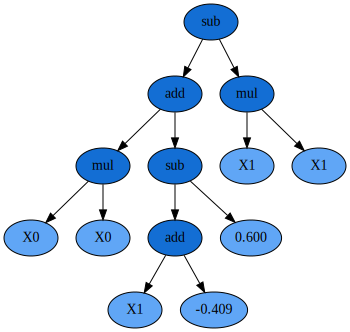

In [14]:
import graphviz 

dot_data = est_gp._program.export_graphviz()
graph = graphviz.Source(dot_data)
graph

## 训练DecisionTree & RandomForest

In [15]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

est_tree = DecisionTreeRegressor()
est_tree.fit(X_train, y_train)

est_rf = RandomForestRegressor()
est_rf.fit(X_train, y_train)

RandomForestRegressor()

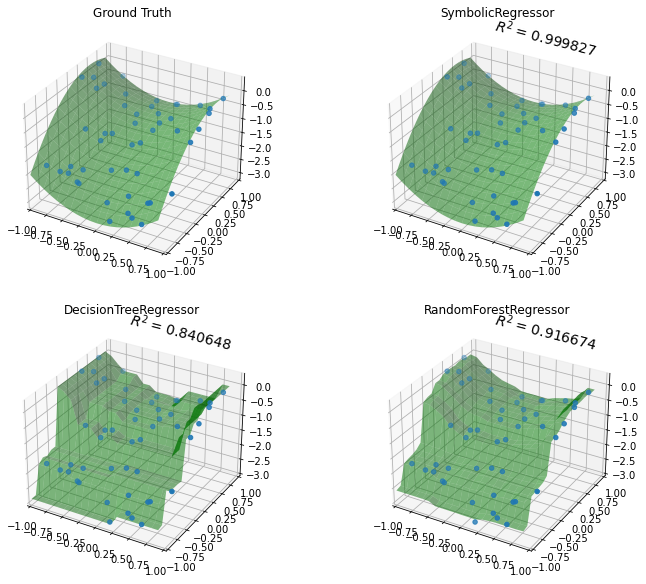

In [16]:
y_gp = est_gp.predict(np.c_[x0.ravel(), x1.ravel()]).reshape(x0.shape)
score_gp = est_gp.score(X_test, y_test)
y_tree = est_tree.predict(np.c_[x0.ravel(), x1.ravel()]).reshape(x0.shape)
score_tree = est_tree.score(X_test, y_test)
y_rf = est_rf.predict(np.c_[x0.ravel(), x1.ravel()]).reshape(x0.shape)
score_rf = est_rf.score(X_test, y_test)

fig = plt.figure(figsize=(12, 10))

for i, (y, score, title) in enumerate([(y_truth, None, "Ground Truth"),
                                        (y_gp, score_gp, "SymbolicRegressor"),
                                        (y_tree, score_tree, "DecisionTreeRegressor"),
                                        (y_rf, score_rf, "RandomForestRegressor")]):

    ax = fig.add_subplot(2, 2, i+1, projection='3d')
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)
    surf = ax.plot_surface(x0, x1, y, rstride=1, cstride=1, color='green', alpha=0.5)
    points = ax.scatter(X_train[:, 0], X_train[:, 1], y_train)
    if score is not None:
        score = ax.text(-.7, 1, .2, "$R^2 =\/ %.6f$" % score, 'x', fontsize=14)
    plt.title(title)
plt.show()

## Custom Metric & Function

In [29]:
from gplearn import fitness
from gplearn.genetic import SymbolicRegressor, SymbolicClassifier
from sklearn.metrics import mean_absolute_error

def my_gplearn_score_func(y, y_pred, sample_weight):
    """ 
        input:
            y:             本例中不重要，从外部传入表现评估所需字段
            y_pred:        input_signal
            sample_weight: 本例中不存在权重优化
    """
    score = mean_absolute_error(y, y_pred)
    return score

m = fitness.make_fitness(function=my_gplearn_score_func, 
                         greater_is_better=False, 
                         wrap=False)
m

In [19]:
est_gp = SymbolicRegressor(population_size=5000, 
                           metric=m,
                           generations=20, 
                           stopping_criteria=0.01,
                           p_crossover=0.7, 
                           p_subtree_mutation=0.1,
                           p_hoist_mutation=0.05, 
                           p_point_mutation=0.1,
                           max_samples=0.9, verbose=1,
                           parsimony_coefficient=0.01, 
                           random_state=0)
est_gp.fit(X_train, y_train)

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    38.13          424.564        5         0.344276         0.344276      1.19m
   1     9.96           1.7132        9         0.344135         0.344135     49.15s
   2     7.74          2.00805        7         0.259453         0.259453     45.56s
   3     5.29         0.987923        7         0.257138         0.257138     43.27s
   4     4.40          0.79238        7         0.257138         0.257138     38.46s
   5     6.33         0.949751       11        0.0436126        0.0436126     36.14s
   6     7.21          1.10669       11        0.0436126        0.0436126     33.97s
   7     7.55          1.87504       11        0.0436126        0.0436126     32.48s
   8     8.26         0.976481       11        0.0436126        0.0436126  

SymbolicRegressor(max_samples=0.9,
                  metric=<gplearn.fitness._Fitness object at 0x000001312E8F1780>,
                  p_crossover=0.7, p_hoist_mutation=0.05, p_point_mutation=0.1,
                  p_subtree_mutation=0.1, parsimony_coefficient=0.01,
                  population_size=5000, random_state=0, stopping_criteria=0.01,
                  verbose=1)

# Geatpy2
http://geatpy.com/index.php/details/

## 面向脚本的编程方式
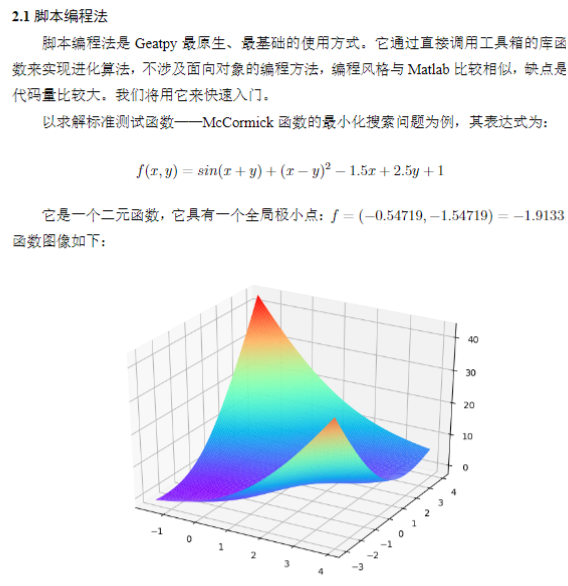

In [ ]:
#-*-coding:utf-8-*-
"""demo.py"""
import numpy as np
import geatpy as ea#导入geatpy库
import time

- FieldD
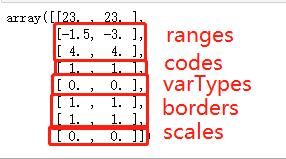

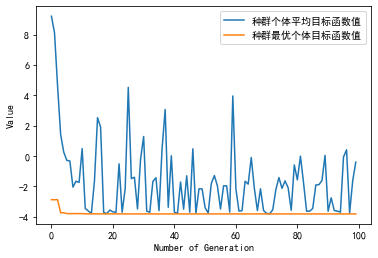

In [56]:
"""============================目标函数============================"""
def aim(Phen):        
    """   
        # 传入种群染色体矩阵解码后的基因表现型矩阵 | (NIND, variable_cnt)
    """
    x1 = Phen[:, [0]] # 取出第一列，得到所有个体的第一个自变量
    x2 = Phen[:, [1]] # 取出第二列，得到所有个体的第二个自变量        
    score = np.sin(x1 + x2) + (x1 - x2) ** 2 - 1.5 * x1 + 2.5 * x2 +1    # (NIND, 1)

    return score


"""============================变量设置============================"""
x1 = [-1.5, 4]      # 第一个决策变量范围
b1 = [1, 1]         # 第一个决策变量边界，1表示包含范围的边界，0表示不包含

x2 = [-3, 4]        # 第二个决策变量范围
b2 = [1, 1]         # 第二个决策变量边界，1表示包含范围的边界，0表示不包含

ranges=np.vstack([x1, x2]).T   # 生成自变量的范围矩阵，使得第一行为所有决策变量的下界，第二行为上界 | (2, 2)
borders=np.vstack([b1, b2]).T  # 生成自变量的边界矩阵                                               | (2, 2)
varTypes = np.array([0, 0])    # 决策变量的类型，0表示连续，1表示离散                               | (2,  )


"""==========================染色体编码设置========================="""
Encoding ='BG'     # 'BG'表示采用二进制/格雷编码
codes = [1, 1]     # 决策变量的编码方式，两个1表示变量均使用格雷编码
precisions =[6, 6] # 决策变量的编码精度，表示解码后能表示的决策变量的精度可达到小数点后6位
scales = [0, 0]    # 0表示采用算术刻度，1表示采用对数刻度

# 调用函数创建译码矩阵 | (8,2)
FieldD =ea.crtfld(Encoding,
                  varTypes,  # (2, )
                  ranges,    # (2,2)
                  borders,   # (2,2)
                  precisions,# (2, )
                  codes,     # (2,)
                  scales     # (2,)
                 )    


"""=========================遗传算法参数设置========================"""
NIND     = 20                        # 种群个体数目
MAXGEN   = 100                       # 最大遗传代数
Lind =int(np.sum(FieldD[0, :]))      # 计算染色体长度 | 46
maxormins = np.array([1])            # 表示目标函数是最小化，元素为-1则表示对应的目标函数是最大化

selectStyle ='sus'                   # 采用随机抽样选择

recStyle ='xovdp'                    # 采用两点交叉
pc= 0.9                              # 交叉概率

mutStyle ='mutbin'                   # 采用二进制染色体的变异算子
pm= 1/Lind                           # 变异概率

obj_trace = np.zeros((MAXGEN, 2))    # 定义目标函数值记录器
var_trace = np.zeros((MAXGEN, Lind)) # 染色体记录器，记录历代最优个体的染色体


"""=========================开始遗传算法进化========================"""
start_time = time.time()                # 开始计时

Chrom = ea.crtpc(Encoding, NIND, FieldD)# 生成种群染色体矩阵 | (20, 46)
variable = ea.bs2ri(Chrom, FieldD)      # 对初始种群进行解码 | (20, 2)
ObjV = aim(variable)                    # 计算初始种群个体的目标函数值 | (20, 1)
best_ind = np.argmin(ObjV)              # 计算当代最优个体的序号

# 开始进化
for gen in range(MAXGEN):
    FitnV = ea.ranking(maxormins * ObjV)                      # 根据目标函数大小分配适应度值（）
    SelCh = Chrom[ea.selecting(selectStyle, FitnV, NIND-1),:] # 选择（selectStyle, FitnV。 NIND-1）

    SelCh = ea.recombin(recStyle, SelCh, pc)                  # 重组（recStyle, pc）
    SelCh = ea.mutate(mutStyle, Encoding, SelCh, pm)          # 变异（mutStyle, Encoding, pm）
    
    Chrom = np.vstack([Chrom[best_ind, :], SelCh]) # 把父代精英个体与子代的染色体进行合并，得到新一代种群
    Phen = ea.bs2ri(Chrom, FieldD)                 # 对种群进行解码(二进制转十进制)
    ObjV = aim(Phen)                               # 求种群个体的目标函数值

    # 记录
    best_ind = np.argmin(ObjV)                     # 计算当代最优个体的序号
    obj_trace[gen, 0]=np.sum(ObjV)/ObjV.shape[0]   # 记录当代种群的目标函数均值
    obj_trace[gen, 1]=ObjV[best_ind]               # 记录当代种群最优个体目标函数值
    var_trace[gen, :]=Chrom[best_ind,:]            # 记录当代种群最优个体的染色体

# 进化完成
end_time = time.time() # 结束计时
ea.trcplot(obj_trace, [['种群个体平均目标函数值','种群最优个体目标函数值']]) # 绘制图像


In [57]:
"""============================输出结果============================"""
best_gen = np.argmin(obj_trace[:, [1]])
print('最优解的目标函数值：', obj_trace[best_gen, 1])
variable = ea.bs2ri(var_trace[[best_gen], :], FieldD)

#解码得到表现型（即对应的决策变量值）
print('最优解的决策变量值为：')
for i in range(variable.shape[1]):
    print('x'+str(i)+'=',variable[0, i])
    print('用时：', end_time - start_time,'秒')


最优解的目标函数值： -3.8264459096689736
最优解的决策变量值为：
x0= -0.5471985396383452
用时： 0.038727760314941406 秒
x1= -1.5471878704056585
用时： 0.038727760314941406 秒


## 面向对象的编程方式
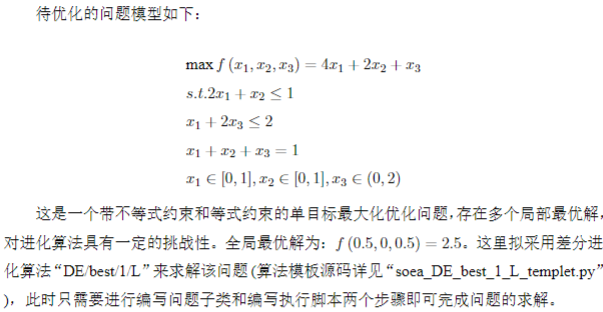

In [24]:
#-*-coding:utf-8-*-
import numpy as np
import geatpy as ea
"""MyProblem.py"""

In [33]:
class MyProblem(ea.Problem):  # 继承Problem父类
    def __init__(self):
        name ='MyProblem'     # 初始化name（函数名称，可以随意设置）
        M = 1                 # 初始化M（目标维数）
        maxormins = [-1]      # 初始化目标最小最大化标记列表，1：min；-1：max
        Dim = 3               # 初始化Dim（决策变量维数）

        varTypes = [0] * Dim  # 初始化决策变量类型，0：连续；1：离散
        lb = [0,0,0]          # 决策变量下界
        ub = [1,1,2]          # 决策变量上界
        lbin = [1,1,0]        # 决策变量下边界
        ubin = [1,1,0]        # 决策变量上边界
        
        # 调用父类构造方法完成实例化
        ea.Problem.__init__(self, name, M, maxormins, Dim, varTypes, lb,ub, lbin, ubin)
        
    def aimFunc(self, pop): 
        """ 目标函数，pop为传入的种群对象 """
        Vars = pop.Phen     # 得到决策变量矩阵
        x1 = Vars[:, [0]]   # 取出第一列得到所有个体的x1组成的列向量
        x2 = Vars[:, [1]]   # 取出第二列得到所有个体的x2组成的列向量
        x3 = Vars[:, [2]]   # 取出第三列得到所有个体的x3组成的列向量

        # 计算目标函数值，赋值给pop种群对象的ObjV属性
        pop.ObjV = 4*x1 + 2*x2 + x3

        # 采用可行性法则处理约束，生成种群个体违反约束程度矩阵
        pop.CV = np.hstack([2*x1 + x2 - 1,            # 第一个约束
                            x1 + 2*x3 - 2,            # 第二个约束
                            np.abs(x1 + x2 + x3 - 1)])# 第三个约束
    
    # def aimFunc(self, pop):    # 目标函数，pop为传入的种群对象
    #     Vars = pop.Phen        # 得到决策变量矩阵
    #     x1 = Vars[:, [0]]      # 取出第一列得到所有个体的x1组成的列向量
    #     x2 = Vars[:, [1]]      # 取出第二列得到所有个体的x2组成的列向量
    #     x3 = Vars[:, [2]]      # 取出第三列得到所有个体的x3组成的列向量
    #     f = 4*x1 + 2*x2 + x3  # 计算目标函数值#采用罚函数法处理约束
    #     exIdx1 = np.where(2*x1+x2>1)[0]    # 找到违反约束条件1的个体索引
    #     exIdx2 = np.where(x1+2*x3>2)[0]    # 找到违反约束条件2的个体索引
    #     exIdx3 = np.where(x1+x2+x3!=1)[0]  # 找到违反约束条件3的个体索引
    #     exIdx = np.unique(np.hstack([exIdx1,exIdx2,exIdx3])) # 合并索引
    #     alpha = 2     # 惩罚缩放因子
    #     beta = 1      # 惩罚最小偏移量
    #     f[exIdx] += self.maxormins[0]*alpha *(np.max(f)-np.min(f)+beta)
    #     pop.ObjV = f  # 把目标函数值矩阵赋值给种群的ObjV属性
        

gen|  eval  |    f_opt    |    f_max    |    f_avg    |    f_min    |    f_std    
----------------------------------------------------------------------------------
100|  2020  | 1.66476E+00 | 1.66476E+00 | 1.66475E+00 | 1.66474E+00 | 5.03621E-06 
200|  4020  | 1.80688E+00 | 1.80688E+00 | 1.80685E+00 | 1.80676E+00 | 3.12369E-05 
300|  6020  | 1.80688E+00 | 1.80688E+00 | 1.80688E+00 | 1.80688E+00 | 2.64772E-11 
400|  8020  | 1.80688E+00 | 1.80688E+00 | 1.80688E+00 | 1.80688E+00 | 1.43742E-11 
500| 10020  | 1.80735E+00 | 1.80735E+00 | 1.80725E+00 | 1.80710E+00 | 6.81128E-05 
600| 12020  | 1.99990E+00 | 1.99990E+00 | 1.99990E+00 | 1.99990E+00 | 1.91029E-08 
700| 14020  | 1.99990E+00 | 1.99990E+00 | 1.99990E+00 | 1.99990E+00 | 4.44089E-16 
800| 16020  | 1.99990E+00 | 1.99990E+00 | 1.99990E+00 | 1.99990E+00 | 4.44089E-16 
900| 18020  | 1.99990E+00 | 1.99990E+00 | 1.99990E+00 | 1.99990E+00 | 4.44089E-16 
999| 20000  | 1.99990E+00 | 1.99990E+00 | 1.99990E+00 | 1.99990E+00 | 4.44089E-16 


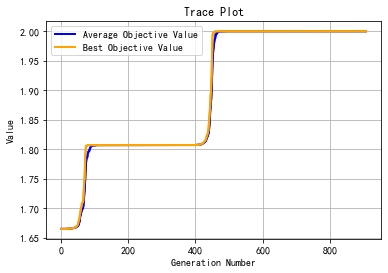

评价次数：20000
时间已过0.34198474884033203秒
最优的目标函数值为：1.9998999999999594
最优的控制变量值为：
0.0
0.9998999999999594
0.0001000000000405884
没找到可行解


In [35]:
#-*-coding:utf-8-*-
"""main.py"""
import geatpy as ea             # import geatpy
# from MyProblem import MyProblem # 导入自定义问题接口

"""============================实例化问题对象========================"""
problem = MyProblem() # 实例化问题对象

"""==============================种群设置==========================="""
Encoding ='RI' # 编码方式
NIND = 50      # 种群规模
Field = ea.crtfld(Encoding, problem.varTypes, problem.ranges,problem.borders) # 创建区域描述器
population = ea.Population(Encoding, Field, NIND)
# 实例化种群对象（此时种群还没被真正初始化，仅仅是生成一个种群对象）

"""===========================算法参数设置=========================="""
myAlgorithm = ea.soea_DE_best_1_L_templet(problem, population) # 实例化一个算法模板对象
myAlgorithm.MAXGEN = 1000      # 最大进化代数
myAlgorithm.mutOper.F = 0.5    # 差分进化中的参数F
myAlgorithm.recOper.XOVR = 0.7 # 设置交叉概率
myAlgorithm.logTras = 100      # 设置每隔多少代记录日志，若设置成0则表示不记录日志
myAlgorithm.verbose = True    # 设置是否打印输出日志信息
myAlgorithm.drawing = 1        # 设置绘图方式（0：不绘图；1：绘制结果图；2：绘制目标空间过程动画；3：绘制决策空间过程动画）

"""==========================调用算法模板进行种群进化==============="""
[BestIndi, population] = myAlgorithm.run() # 执行算法模板，得到最优个体以及最后一代种群
BestIndi.save()                            # 把最优个体的信息保存到文件中

"""=================================输出结果======================="""
print('评价次数：%s'% myAlgorithm.evalsNum)
print('时间已过%s秒'% myAlgorithm.passTime)

if BestIndi.sizes != 0:
    print('最优的目标函数值为：%s'% BestIndi.ObjV[0][0])
    print('最优的控制变量值为：')
    for i in range(BestIndi.Phen.shape[1]):
        print(BestIndi.Phen[0, i])
    else:
        print('没找到可行解')


# Deap
https://deap.readthedocs.io/en/master/

## 定义primitive set

In [1]:
import math
import operator
import deap
from deap import creator, base, tools, gp
import numpy as np
import random
from matplotlib import pyplot as plt

np.random.seed(1)
random.seed(1)

In [2]:
# 使用猴子补丁缓解同名Ephemerals异常
import warnings
def addEphemeralConstant(self, name, ephemeral, ret_type):
    module_gp = globals()
    if name not in module_gp:
        pass
    else:
        class_ = module_gp[name]
        if issubclass(class_, gp.Ephemeral):
            if class_.func is not ephemeral:
                warnings.warn("Ephemerals with different functions should "
                                "be named differently, even between psets."
                                "The previous one has been overridden.")
            elif class_.ret is not ret_type:
                warnings.warn("Ephemerals with the same name and function "
                                "should have the same type, even between psets."
                                "The previous one has been overridden.")
        else:
            warnings.warn("Ephemerals should be named differently "
                            "than classes defined in the gp module."
                            "The previous one has been overridden.")
    class_ = type(name, (gp.Ephemeral,), {'func': staticmethod(ephemeral),
                                            'ret': ret_type})
    module_gp[name] = class_
    self._add(class_)
    self.terms_count += 1

gp.PrimitiveSetTyped.addEphemeralConstant=addEphemeralConstant

In [4]:
"""================= gplearn相关参数 ==================
    1. function_set = ('add', 'sub', 'mul', 'div'),
    2. const_range = (-1., 1.)
    3. random_state = 0
"""


# 定义 primitive set
def protectedDiv(left,right):
    if right == 0:
        return 1
    else:
        return left / right

pset = gp.PrimitiveSet('main', 2)
pset.renameArguments(ARG0 = 'x0')
pset.renameArguments(ARG1 = 'x1')

pset.addPrimitive(operator.add, 2)
pset.addPrimitive(operator.sub, 2)
pset.addPrimitive(operator.mul, 2)
pset.addPrimitive(protectedDiv, 2)
#pset.addPrimitive(operator.neg, 1)
#pset.addPrimitive(math.sin, 1)
#pset.addPrimitive(math.cos, 1)

# 简单删除之前的定义的rand1全局变量
# if "rand1" in dir(gp):
#     del gp.rand1

pset.addEphemeralConstant('rand1', lambda: round(np.random.uniform(-1., 1.), 3))

C:\Users\admin\AppData\Local\Temp\ipykernel_23888\3119706017.py:11: UserWarning: Ephemerals with different functions should be named differently, even between psets.The previous one has been overridden.
  warnings.warn("Ephemerals with different functions should "


## 创建fitness类、individual类

In [5]:
# 创建fitness类、individual类
creator.create('FitnessMin', base.Fitness, weights = (-1.0, ))
creator.create('Individual', gp.PrimitiveTree, fitness = creator.FitnessMin)

#creator.create("FitnessMin", base.Fitness, weights=(-1.0, -1.0))
#creator.create('Individual', gp.PrimitiveTree, fitness = creator.FitnessMin)

## 定义个体的生成方法、种群的生成方法

In [6]:
"""================= gplearn相关参数 ==================
    4. init_depth  = (2, 6)
    5. init_method = 'half-and-half'
"""

# 定义个体的生成方法、种群的生成方法
tool = base.Toolbox()

tool.register('expr', gp.genHalfAndHalf, pset = pset, min_ = 2, max_ = 6)
tool.register('individual', tools.initIterate, creator.Individual, tool.expr)
tool.register('population', tools.initRepeat, list, tool.individual)
tool.register('compile', gp.compile, pset = pset)

## 定义evaluate、select、mate、mutate（这几个名字必须这样取，否则出错）

In [7]:
"""================= gplearn相关参数 ==================
    6. metric = mean_absolute_error
    7. parsimony_coefficient = 0.01
    8. tournament_size = 20
"""
from sklearn.metrics import mean_absolute_error
metric = mean_absolute_error
parsimony_coefficient = 0.01
tournament_size = 20

   # pset上面已经给过了

# 定义evaluate、select、mate、mutate（这几个名字必须这样取，否则出错）
#def fit_evaluation(individual, X, y, metric, parsimony_coef):    
#    func = tool.compile(expr=individual)
#    y_pred = np.array([func(x0, x1) for (x0, x1) in X])
#    metric_value = metric(y, y_pred)
#    parsimony_v = len(individual) * parsimony_coef
#    score = metric_value + parsimony_v
#    return (score, metric_value, parsimony_v) # 必须返回一个tuple
#tool.register('evaluate', fit_evaluation, X=X_train, y=y_train, metric=metric, parsimony_coef=parsimony_coefficient)

def fit_evaluation(individual, t, X, y, metric, parsimony_coef):    
    func = t.compile(expr=individual)
    y_pred = np.array([func(x0, x1) for (x0, x1) in X])
    metric_value = metric(y, y_pred)
    parsimony_v = len(individual) * parsimony_coef
    score = metric_value + parsimony_v
    return (score, metric_value, parsimony_v) # 必须返回一个tuple
tool.register('evaluate', fit_evaluation, t=tool, X=X_train, y=y_train, metric=metric, parsimony_coef=parsimony_coefficient)

tool.register('select', tools.selTournament, tournsize=tournament_size)  # 选择最优N个
tool.register('mate', gp.cxOnePoint)                                     # 单点交叉 会产生两棵树(a field guide里说一般只用一棵树) 
tool.register('expr_mut', gp.genFull, pset=pset, min_ = 0, max_ = 2)     # 生成一个subtree
tool.register('mutate', gp.mutUniform, expr=tool.expr_mut, pset=pset)    # subtree mutation    

# 限制一下交叉变异后的树深度，根据Koza的论文，最大17
# tool.decorate('mate', gp.staticLimit(key=operator.attrgetter('height'), max_value=13))   
# tool.decorate('mutate', gp.staticLimit(key=operator.attrgetter('height'), max_value=13))

## 生成初始种群并进化迭代

In [8]:
# 参数设置
popSize = 5000  #种群规模
ngen = 20       #迭代次数
cxpb = 0.7      #交叉概率
mutpb = 0.3     #变异概率

stopping_criteria = 0.01  # 提前停止

"""================= gplearn相关参数 ==================
   9.  population_size = 5000
   10. generations = 10
   11. stopping_criteria = 0.01
   12. 
       p_crossover=0.7,         # The probability of performing crossover on a tournament winner.
       p_subtree_mutation=0.1,  # The probability of performing subtree mutation on a tournament winner.
       p_hoist_mutation=0.05,   # The probability of performing hoist mutation on a tournament winner.
       p_point_mutation=0.1,    # The probability of performing point mutation on a tournament winner.
       p_point_replace=0.05,    # For point mutation only, the probability that any given node will be mutated.
"""

# 生成初始种群
pop = tool.population(n=popSize)

# 求初始种群的每个个体的适应度值，是一个list
fitnesses = list(map(tool.evaluate, pop)) 

# 给每个ind的fitness赋值
for ind, fit in zip(pop, fitnesses):
    ind.indicators = fit
    ind.fitness.values = (fit[0], )

best_inds = []    # 记录每一代的最优个体
hof = tools.HallOfFame(1)  

hof.update(pop)
best_ind = hof.items[0]
best_inds.append(best_ind)

# stats = tools.Statistics(lambda ind: ind.fitness.values)
# stats.register('avg', np.mean, axis = 0)   
# stats.register('std', np.std, axis = 0)
# stats.register('min', np.min, axis = 0)
# stats.register('max', np.max, axis = 0)

# # record是一个字典：
# #  处理前：record {‘avg’：array([]), 'std':array([]),  ...}, 每个value是一个list
# #  处理后：record { 'avg': XXX, 'std':XXX, ...}，每个value是一个value
# record = stats.compile(pop)   
# for key in record:
#     record[key] = record[key][0]
# logbook = tools.Logbook()
# logbook.record(gen=0, eval=popSize, best_ind=best_ind, **record)
# logbook.header = 'gen', 'avg', 'eval', #'std', 'min', 'max', 'best_ind'

record = {
    'Avg_Length':       np.mean([len(p) for p in pop]),
    'Avg_Fitness':      np.mean([p.fitness.values[0] for p in pop]),
    'Best_Ind_Length':  len(best_ind),
    'Best_Ind_Fitness': best_ind.fitness.values[0],
}
logbook = tools.Logbook()
logbook.record(gen=0, eval=popSize, **record)
logbook.header = 'gen', 'eval', 'Avg_Length', 'Avg_Fitness', 'Best_Ind_Length', 'Best_Ind_Fitness',

print('--------开始迭代--------')
for g in range(ngen):
    # select  选出popSize个个体进入下一代
    offSpring = tool.select(pop, len(pop))  
    offSpring = list(map(tool.clone, offSpring))

    # crossover  依次两两交叉
    for child1,child2 in zip(offSpring[1::2],offSpring[::2]):
        if np.random.random() < cxpb:
            tool.mate(child1,child2)    # 交叉产生两个新的个体
            del child1.fitness.values   # 新的个体需要重新evaluate，所以删掉原来的fitness value
            del child2.fitness.values

    # mutate  变异
    for child in offSpring:       # 每个个体都有概率进行变异
        if np.random.random() < mutpb:
            tool.mutate(child)
            del child.fitness.values

    # evaluate  进化 
    invalid_fit = []      # 找到需要重新计算fitness的个体
    for ind in offSpring:
        if not ind.fitness.valid:
            invalid_fit.append(ind)
    fitnesses = list(map(tool.evaluate, invalid_fit))
    for ind, fit in zip(invalid_fit, fitnesses):
        ind.indicators = fit
        ind.fitness.values = (fit[0], ) # fitness 是用score = 

    # 更新种群
    pop = offSpring           
    hof.update(pop)           
    # 找到本代的最优个体
    best_ind = hof.items[0]   
    best_inds.append(best_ind)

    print('第',g+1,'次迭代')
    
    #     record = stats.compile(pop)  # 数据统计
    #     for key in record:
    #         record[key] = record[key][0] # 只记录 metric_value，不记录 parsimony_value
    #     logbook.record(gen=g+1, eval=len(invalid_fit), best_ind=best_ind, **record)
    
    record = {  'Avg_Length':       np.mean([len(p) for p in pop]),
                'Avg_Fitness':      np.mean([p.indicators[1] for p in pop]),
                'Best_Ind_Length':  len(best_ind),
                'Best_Ind_Fitness': best_ind.indicators[1],
    }
    logbook.record(gen=g+1, eval=len(invalid_fit), **record)
    
    # 若 metric_value 达到stopping_criteria，提前中止迭代
    if best_ind.indicators[1]<stopping_criteria:
        break 

print('--------迭代结束-------')
print(logbook)

--------开始迭代--------
第 1 次迭代
第 2 次迭代
第 3 次迭代
第 4 次迭代
第 5 次迭代
第 6 次迭代
--------迭代结束-------
gen	eval	Avg_Length	Avg_Fitness	Best_Ind_Length	Best_Ind_Fitness
0  	5000	33.0144   	9.81425e+11	7              	0.342142        
1  	3973	10.988    	2.6488     	7              	0.272142        
2  	4004	9.7456    	1.375      	15             	0.146607        
3  	3930	7.748     	1.39762    	15             	0.146607        
4  	4021	7.262     	0.910744   	15             	0.146607        
5  	3907	8.4684    	0.901408   	13             	0.123196        
6  	3958	11.6188   	0.964949   	13             	2.88658e-17     


## Best Individual Performance

In [9]:
print(best_ind)

add(mul(add(x1, x0), sub(x0, x1)), sub(x1, protectedDiv(x1, x1)))


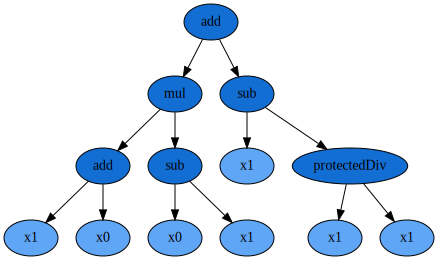

In [10]:
import graphviz 

""" 绘制 Syntax Tree """
def get_dot_data(individual, pset):
    nodes, edges, labels = gp.graph(individual)
    arguments = pset.arguments
    
    def format_node(node, labels, arguments):
        label = labels[node]
        fillcolor = '#136ed4' if label not in arguments else '#60a6f6' 
        str_format = '{} [label="{}", fillcolor="{}"] ;'.format(node, label, fillcolor)
        return str_format
    
    def format_edge(edge):
        str_format = '{} -> {} ;'.format(edge[0], edge[1])
        return str_format

    node_process = 0
    str_format_tree_list = []
    for edge in edges:
        # edge[1]的node还没有str_format，则先顺序str_format
        while node_process <= edge[1]:
            str_format_tree_list.append(format_node(node_process, labels, arguments))
            node_process += 1
        # str_format edge
        str_format_tree_list.append(format_edge(edge))
    # 生成dot_data
    dot_data = '\n'.join(['digraph program {', 'node [style=filled]'] + str_format_tree_list + ['}'])
    return dot_data
    
dot_data = get_dot_data(best_ind, pset)
graph = graphviz.Source(dot_data)
graph

## Compare with Other Models

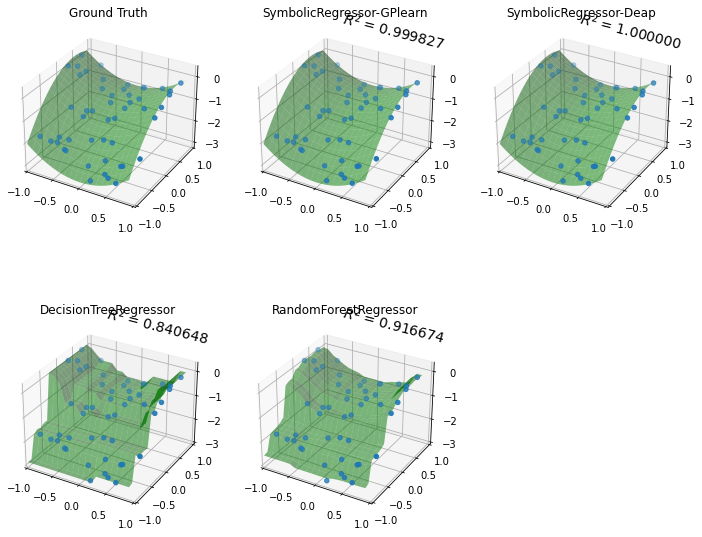

In [17]:
from sklearn.metrics import r2_score

y_gp = est_gp.predict(np.c_[x0.ravel(), x1.ravel()]).reshape(x0.shape)
score_gp = est_gp.score(X_test, y_test)
y_tree = est_tree.predict(np.c_[x0.ravel(), x1.ravel()]).reshape(x0.shape)
score_tree = est_tree.score(X_test, y_test)
y_rf = est_rf.predict(np.c_[x0.ravel(), x1.ravel()]).reshape(x0.shape)
score_rf = est_rf.score(X_test, y_test)

func = tool.compile(expr=best_ind)
y_deap = np.array([func(vx0, vx1) for vx0, vx1 in zip(x0.flatten(), x1.flatten())]).reshape(y_truth.shape)
y_test_deap = np.array([func(vx0, vx1) for (vx0, vx1) in X_test]).reshape(y_test.shape)
score_deap = r2_score(y_test_deap, y_test)

fig = plt.figure(figsize=(12, 10))

for i, (y, score, title) in enumerate([(y_truth, None,       "Ground Truth"),
                                        (y_gp,    score_gp,   "SymbolicRegressor-GPlearn"),
                                        (y_deap,  score_deap, "SymbolicRegressor-Deap"),
                                        (y_tree, score_tree, "DecisionTreeRegressor"),
                                        (y_rf, score_rf, "RandomForestRegressor")]):

    ax = fig.add_subplot(2, 3, i+1, projection='3d')
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)
    surf = ax.plot_surface(x0, x1, y, rstride=1, cstride=1, color='green', alpha=0.5)
    points = ax.scatter(X_train[:, 0], X_train[:, 1], y_train)
    if score is not None:
        score = ax.text(-.7, 1, .2, "$R^2 =\/ %.6f$" % score, 'x', fontsize=14)
    plt.title(title)
plt.show()

# Deap 建个Class，像GPLearn一样用

## 构建（随便一堆）

In [3]:
import math
import operator
import deap
from deap import creator, base, tools, gp
import numpy as np
import random
from matplotlib import pyplot as plt
import graphviz 

class MyDeapGPLearn():
    def __init__(self,
                 function_set=('add', 'sub', 'mul', 'div','sin','cos','tan'),
                 const_range=(-1.0, 1.0), 
                 
                 random_state=0,
                 
                 init_depth=(2, 6), 
                 init_method='half and half',
                  
                 metric=None,
                 parsimony_coefficient=0.001,

                 population_size=100, 
                 tournament_size=10, 
                 generations=10, 
                 stopping_criteria=10.0,                                
                  
                 p_crossover=0.9, 
                 p_mutation = 0.1,
                 
                 # p_subtree_mutation=0.01, p_hoist_mutation=0.01, p_point_mutation=0.01, p_point_replace=0.05,
                 # max_samples=1.0,
                 # feature_names=None, warm_start=False, low_memory=False, n_jobs=1, verbose=1, 
                 
                 **kwargs
                 ):
        """ 输入参数仿照GPLearn，在Fit时进行应用"""

        self.param_dict = {
            'function_set':    function_set,
            'const_range':     const_range,
            'random_state':    random_state,
            'init_depth':      init_depth, 
            'init_method':     init_method,
            'metric':          metric,
            'parsimony_coef':  parsimony_coefficient,
            'population_size': population_size, 
            'tournament_size': tournament_size, 
            'generations':     generations, 
            'stopping_criteria': stopping_criteria,  
            'p_crossover':     p_crossover, 
            'p_mutation':      p_mutation
        }
        self.param_dict.update(kwargs)
        
        np.random.seed(random_state)
        random.seed(random_state)
        
        self.pset = None
        self.tool = None

        self.logbook = None
        self.best_inds = []
        self.best_ind = None
        
    def fit(self, X, y):
        """ 仿照GPLearn进行fit """
        # 1. 生成 primitive Set
        self.pset = self._generate_pset(self.param_dict['function_set'], 
                                        self.param_dict['const_range'], 
                                        X.shape[1])
        self.tool = base.Toolbox()
        
        # 2. Fitness默认越小越好，构造metric的时候处理一下就好
        self._generate_fitness_individual()
        
        # 3. 定义个体（Individual）、总体（Population）生成方式
        self._register_init_methods(self.tool, self.pset, 
                                    self.param_dict['init_depth'], 
                                    self.param_dict['init_method'])
        
        # 4. 定义进化（Evaluate）、选择（Select）方式
        self._register_evaluate_select_methods(self.tool, X, y, 
                                               self.param_dict['metric'], 
                                               self.param_dict['parsimony_coef'], 
                                               self.param_dict['tournament_size'], 
                                               self.param_dict)
        
        # 5. 定义交叉（Mate）、变异（Mutate）的方式
        self._register_mate_mutate_methods(self.tool, self.pset)
        
        # 6.  迭代训练
        self._fit(self.tool, 
                  self.param_dict['population_size'], 
                  self.param_dict['generations'], 
                  self.param_dict['stopping_criteria'], 
                  self.param_dict['p_crossover'], 
                  self.param_dict['p_mutation'])
                
    def predict(self, X):
        """ 仿照GPLearn进行predict """
        func = self.tool.compile(expr=self.best_ind)
        Xs = ','.join(['x{}'.format(i) for i in range(X.shape[1])])
        exec_sent = "[y_pred.append(func(%s)) for (%s) in X]" % (Xs, Xs)
        print(exec_sent)        
        
        y_pred = []
        exec(exec_sent, {'func': func, 'X': X, 'y_pred': y_pred})
        y_pred = np.array(y_pred).reshape((X.shape[0], ))
        return y_pred
    
    def _generate_pset(self, function_set, const_range, argument_size):
        """ 生成primitive set (terminal + ) """
        # argument_size
        pset = gp.PrimitiveSet('main', argument_size)
        for i in range(argument_size):
            # pset.renameArguments(ARG0='x{}'.format(i))
            exec( "pset.renameArguments(ARG%i='%s')"%(i, 'x{}'.format(i)) )
        
        # function_set
        def protectedDiv(left,right):
            return 1 if right == 0 else left / right
        map_dict = {
            'add': (operator.add, 2), 
            'sub': (operator.sub, 2),
            'mul': (operator.mul, 2), 
            'div': (protectedDiv, 2),
            'sin': math.sin,
            'cos': math.cos,
            'tan': math.tan
        }
        for symb in function_set:
            pset.addPrimitive(map_dict[symb][0], map_dict[symb][1])
        pset.addPrimitive(operator.neg, 1)
        
        # constant
        const_range_d, const_range_u = const_range
        try:
            pset.addEphemeralConstant('rand1', 
                                      lambda: round(np.random.uniform(const_range_d, const_range_u), 3))
        except:
            pass
        return pset
    
    def _generate_fitness_individual(self):
        """ 
            为Creator 生成Fitness类和Individual类, Fitness默认越小越好
        """
        # 创建fitness类、individual类
        creator.create('FitnessMin', base.Fitness, weights = (-1.0, ))
        creator.create('Individual', gp.PrimitiveTree, fitness = creator.FitnessMin)
    
    def _register_init_methods(self, tool, pset, init_depth, init_method):
        """ 定义个体生成方法，种群生成方法 """
        init_method_dict = {
            'half and half': gp.genHalfAndHalf
        }
        tool.register('expr', init_method_dict[init_method], pset=pset, min_=init_depth[0], max_=init_depth[1])
        tool.register('individual', tools.initIterate, creator.Individual, tool.expr)
        tool.register('population', tools.initRepeat, list, tool.individual)
        tool.register('compile', gp.compile, pset = pset)
    
    def _register_evaluate_select_methods(self, tool, X, y, metric, parsimony_coef, tournament_size, param_dict):
        """ 定义、evaluate、select（这几个名字必须这样取，否则出错） """
        tool.register('evaluate', metric, t=tool, X=X_train, y=y_train, parsimony_coef=parsimony_coef, param_dict=param_dict)
        tool.register('select', tools.selTournament, tournsize=tournament_size)  # 选择最优N个
    
    def _register_mate_mutate_methods(self, tool, pset):
        """ 定义 mate、mutate（这几个名字必须这样取，否则出错） """
        tool.register('mate', gp.cxOnePoint)                                     # 单点交叉 会产生两棵树(a field guide里说一般只用一棵树) 
        tool.register('expr_mut', gp.genFull, pset=pset, min_ = 0, max_ = 2)     # 生成一个subtree
        tool.register('mutate', gp.mutUniform, expr=tool.expr_mut, pset=pset)    # subtree mutation  

        # 限制一下交叉变异后的树深度，根据Koza的论文，最大17
        # tool.decorate('mate', gp.staticLimit(key=operator.attrgetter('height'), max_value=13))   
        # tool.decorate('mutate', gp.staticLimit(key=operator.attrgetter('height'), max_value=13))

    def _fit(self, tool,
             population_size, generations, stopping_criteria, p_crossover, p_mutation):
        """ 迭代训练，获得best_inds """    
        popSize = population_size  #种群规模
        ngen = generations         #迭代次数
        cxpb = p_crossover         #交叉概率
        mutpb =p_mutation          #变异概率
        stopping_criteria = stopping_criteria  # 提前停止

        """================= gplearn相关参数 ==================
           9.  population_size = 5000
           10. generations = 10
           11. stopping_criteria = 0.01
           12. 
               p_crossover=0.7,         # The probability of performing crossover on a tournament winner.
               p_subtree_mutation=0.1,  # The probability of performing subtree mutation on a tournament winner.
               p_hoist_mutation=0.05,   # The probability of performing hoist mutation on a tournament winner.
               p_point_mutation=0.1,    # The probability of performing point mutation on a tournament winner.
               p_point_replace=0.05,    # For point mutation only, the probability that any given node will be mutated.
        """

        # 生成初始种群
        pop = tool.population(n=popSize)

        # 求初始种群的每个个体的适应度值，是一个list
        fitnesses = list(map(tool.evaluate, pop)) 

        # 给每个ind的fitness赋值
        for ind, fit in zip(pop, fitnesses):
            ind.indicators = fit
            ind.fitness.values = (fit[0], )

        best_inds = []    # 记录每一代的最优个体
        hof = tools.HallOfFame(1)  
        hof.update(pop)
        best_ind = hof.items[0]
        best_inds.append(best_ind)

        record = {
            'Avg_Length':       np.mean([len(p) for p in pop]),
            'Avg_Fitness':      np.mean([p.fitness.values[0] for p in pop]),
            'Best_Ind_Length':  len(best_ind),
            'Best_Ind_Fitness': best_ind.fitness.values[0],
        }
        logbook = tools.Logbook()
        logbook.record(gen=0, eval=popSize, **record)
        logbook.header = 'gen', 'eval', 'Avg_Length', 'Avg_Fitness', 'Best_Ind_Length', 'Best_Ind_Fitness',

        print('--------开始迭代--------')
        for g in range(ngen):
            # select  选出popSize个个体进入下一代
            offSpring = tool.select(pop, len(pop))  
            offSpring = list(map(tool.clone, offSpring))

            # crossover  依次两两交叉
            for child1,child2 in zip(offSpring[1::2],offSpring[::2]):
                if np.random.random() < cxpb:
                    tool.mate(child1,child2)    # 交叉产生两个新的个体
                    del child1.fitness.values   # 新的个体需要重新evaluate，所以删掉原来的fitness value
                    del child2.fitness.values

            # mutate  变异
            for child in offSpring:       # 每个个体都有概率进行变异
                if np.random.random() < mutpb:
                    tool.mutate(child)
                    del child.fitness.values

            # evaluate  进化 
            invalid_fit = []      # 找到需要重新计算fitness的个体
            for ind in offSpring:
                if not ind.fitness.valid:
                    invalid_fit.append(ind)
            fitnesses = list(map(tool.evaluate, invalid_fit))
            for ind, fit in zip(invalid_fit, fitnesses):
                ind.indicators = fit
                ind.fitness.values = (fit[0], ) # fitness 是用score = 

            # 更新种群
            pop = offSpring           
            hof.update(pop)           
            # 找到本代的最优个体
            best_ind = hof.items[0]   
            best_inds.append(best_ind)

            print('第',g+1,'次迭代')

            record = {  'Avg_Length': np.mean([len(p) for p in pop]),
                        'Avg_Fitness': np.mean([p.indicators[1] for p in pop]),
                        'Best_Ind_Length': len(best_ind),
                        'Best_Ind_Fitness': best_ind.indicators[1],
            }
            logbook.record(gen=g+1, eval=len(invalid_fit), **record)

            # 若 metric_value 达到stopping_criteria，提前中止迭代
            if best_ind.indicators[1]<stopping_criteria:
                break 

        print('--------迭代结束-------')
        print(logbook)
        
        self.logbook = logbook
        self.best_ind = best_ind
        self.best_iinds = best_inds
    
    def export_best_graphviz(self):
        """ 导出best_ind的dot_data，用于绘制 Syntax Tree """
        individual = self.best_ind
        pset = self.pset
        
        nodes, edges, labels = gp.graph(individual)
        arguments = pset.arguments

        def format_node(node, labels, arguments):
            label = labels[node]
            fillcolor = '#136ed4' if label not in arguments else '#60a6f6' 
            str_format = '{} [label="{}", fillcolor="{}"] ;'.format(node, label, fillcolor)
            return str_format

        def format_edge(edge):
            str_format = '{} -> {} ;'.format(edge[0], edge[1])
            return str_format

        node_process = 0
        str_format_tree_list = []
        for edge in edges:
            # edge[1]的node还没有str_format，则先顺序str_format
            while node_process <= edge[1]:
                str_format_tree_list.append(format_node(node_process, labels, arguments))
                node_process += 1
            # str_format edge
            str_format_tree_list.append(format_edge(edge))
        # 生成dot_data
        dot_data = '\n'.join(['digraph program {', 'node [style=filled]'] + str_format_tree_list + ['}'])
        return dot_data

## 定义metric & 代入执行

In [9]:
from sklearn.metrics import mean_absolute_error

def fit_evaluation(individual, t, X, y, parsimony_coef, param_dict):
    """ metric样例，必须越小越好，
        前三个参数必须为X, y, parsimony_coef，后边为从params_dict根据key获取，key可在实例化时任意传入
    """
    #print(t)
    func = t.compile(expr=individual)   # pset上面已经给过了
    y_pred = np.array([func(x0, x1) for (x0, x1) in X]).reshape(y.shape)
    metric_value = mean_absolute_error(y, y_pred)
    parsimony_v = len(individual) * parsimony_coef
    score = metric_value + parsimony_v
    return (score, metric_value, parsimony_v) # 必须返回一个tuple


deap_gp = MyDeapGPLearn(population_size=5000,         # The number of programs in each generation
                        generations=20,               # The number of generations to evolve.
                        tournament_size=20,           # The number of programs that will compete to become part of the nextgeneration.
                        
                        stopping_criteria=0.01,  # The required metric value required in order to stop evolution early
                        const_range = (-1., 1.), # The range of constants to include in the formulas
                        init_depth  = (2, 6),    # The range of tree depths for the initial population of naive formulas
                        init_method  = 'half and half',

                        function_set = ('add', 'sub', 'mul', 'div'),

                        random_state=1,
                        
                        metric=fit_evaluation, # The name of the raw fitness metric（）
                        parsimony_coefficient=0.01,   # penalizes large programs by adjusting their fitness to be less favorable for selection
 
                        p_crossover=0.7,         # The probability of performing crossover on a tournament winner.
                        p_mutation=0.1,  # The probability of performing subtree mutation on a tournament winner.
                       )

In [11]:
deap_gp.fit(X_train, y_train)

C:\ProgramData\Anaconda3\lib\site-packages\deap\creator.py:141: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
C:\ProgramData\Anaconda3\lib\site-packages\deap\creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


--------开始迭代--------
第 1 次迭代
第 2 次迭代
第 3 次迭代
第 4 次迭代
第 5 次迭代
第 6 次迭代
第 7 次迭代
第 8 次迭代
第 9 次迭代
第 10 次迭代
第 11 次迭代
第 12 次迭代
第 13 次迭代
第 14 次迭代
第 15 次迭代
第 16 次迭代
第 17 次迭代
第 18 次迭代
第 19 次迭代
第 20 次迭代
--------迭代结束-------
gen	eval	Avg_Length	Avg_Fitness	Best_Ind_Length	Best_Ind_Fitness
0  	5000	23.5564   	1.44487e+14	11             	0.458525        
1  	3571	9.7164    	717.322    	5              	0.348525        
2  	3572	9.8432    	1.19991    	5              	0.348525        
3  	3655	7.7338    	1.08235    	5              	0.348525        
4  	3585	5.0992    	1.05264    	5              	0.348525        
5  	3699	5.117     	1.10203    	5              	0.348525        
6  	3682	5.1258    	1.29239    	5              	0.348525        
7  	3663	5.0832    	1.04372    	5              	0.348525        
8  	3624	5.0954    	1.09204    	5              	0.348525        
9  	3683	5.1162    	1.10542    	5              	0.348525        
10 	3647	5.1066    	1.02745    	5              	0.348525        
11 	3709

sub(sub(add(x1, mul(x0, x0)), mul(x1, x1)), protectedDiv(x0, x0))


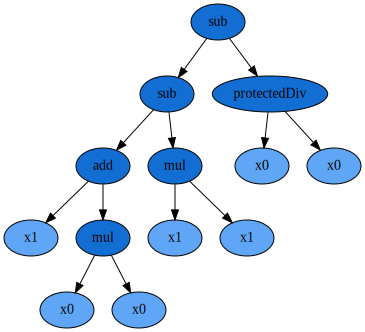

In [6]:
print(deap_gp.best_ind)

import graphviz
dot_data = deap_gp.export_best_graphviz()
graph = graphviz.Source(dot_data)
graph

In [7]:
deap_gp.predict(X_train)

[y_pred.append(func(x0,x1)) for (x0,x1) in X]


array([-0.74531609, -0.87605039, -0.77003778, -0.81481691, -0.42752786,
       -0.60513583, -0.85481647, -1.77155001,  0.14345739, -0.49812695,
        0.15663581, -0.74779276, -0.21561187, -0.39279644, -1.19789706,
       -0.53061285, -0.87417375,  0.10617158, -0.77056444,  0.01905554,
       -1.06284387, -2.49692324, -0.66394884, -1.95741713, -1.2106107 ,
       -1.11816572, -1.47534769, -1.79721496, -1.64310829, -1.76788207,
       -1.92127286, -2.14952464, -0.96323293, -2.04296036, -2.00352213,
       -0.1585741 ,  0.07492525, -2.54202774, -2.14791822, -2.1777835 ,
       -1.06835686, -0.00336821, -1.67164637, -2.46949433, -0.85551703,
       -0.64561528, -0.21224417, -1.85768895, -2.85103402, -2.53910916])

## 参考资料

In [ ]:
def addEphemeralConstant(self, name, ephemeral, ret_type):
        """Add an ephemeral constant to the set. An ephemeral constant
        is a no argument function that returns a random value. The value
        of the constant is constant for a Tree, but may differ from one
        Tree to another.

        :param name: name used to refers to this ephemeral type.
        :param ephemeral: function with no arguments returning a random value.
        :param ret_type: type of the object returned by *ephemeral*.
        """
        module_gp = globals()
        if name not in module_gp:
            class_ = type(name, (Ephemeral,), {'func': staticmethod(ephemeral),
                                               'ret': ret_type})
            module_gp[name] = class_
        else:
            class_ = module_gp[name]
            if issubclass(class_, Ephemeral):
                if class_.func is not ephemeral:
                    raise Exception("Ephemerals with different functions should "
                                    "be named differently, even between psets.")
                elif class_.ret is not ret_type:
                    raise Exception("Ephemerals with the same name and function "
                                    "should have the same type, even between psets.")
            else:
                raise Exception("Ephemerals should be named differently "
                                "than classes defined in the gp module.")

        self._add(class_)
        self.terms_count += 1 

# Geppy
- https://geppy.readthedocs.io/en/latest/overview.html#overview